# LIBRARIES

In [30]:
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, SimpleRNN, GRU, RNN, Bidirectional, TimeDistributed, Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# DATA LOADING

Your training data are 7 descriptive features for past 500K observations.

In [2]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY.head()

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.2017,0.2022,0.2015,0.2017,447,0.2020
1,72,0.2025,0.2028,0.2023,0.2024,592,0.2024
2,63,0.2019,0.2021,0.2017,0.2021,470,0.2020
3,77,0.2016,0.2020,0.2012,0.2019,515,0.2015
4,77,0.2016,0.2019,0.2007,0.2010,682,0.2012


In [13]:
tXY.tail(1)

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
499999,3228,1.1278,1.1361,1.1214,1.1258,3354,1.1266




Your task is to forecast the closing price for all future time steps (index IDs below).


In [3]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id')

# EXPLORATORY DATA ANALYSIS

In [5]:
tXY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Count   500000 non-null  int64  
 1   Open    500000 non-null  float64
 2   High    500000 non-null  float64
 3   Low     500000 non-null  float64
 4   Close   500000 non-null  float64
 5   Volume  500000 non-null  int64  
 6   VWAP    500000 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 30.5 MB


In [42]:
tXY.describe().T

,count,mean,std,min,25%,50%,75%,max
Count,500000.0,240.198048,615.320302,50.0000,69.0000,93.0000,165.0000,44395.0000
Open,500000.0,0.242311,0.335761,0.0406,0.0837,0.1300,0.1883,2.0541
High,500000.0,0.242763,0.336701,0.0422,0.0838,0.1302,0.1884,2.0707
Low,500000.0,0.241912,0.335040,0.0379,0.0837,0.1299,0.1881,2.0448
Close,500000.0,0.242309,0.335758,0.0405,0.0837,0.1300,0.1883,2.0552
Volume,500000.0,1060.068720,865.324214,50.0000,486.0000,826.0000,1371.0000,16749.0000
VWAP,500000.0,0.242306,0.335752,0.0402,0.0837,0.1300,0.1883,2.0529


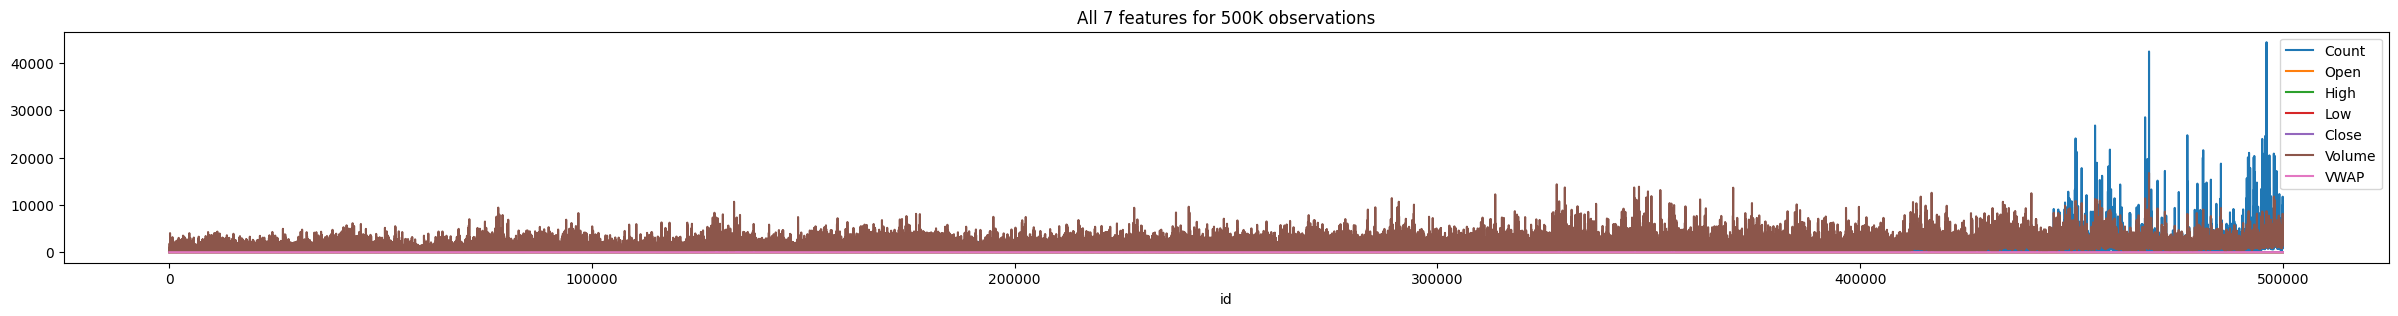

In [44]:
tXY.plot(figsize=(30,3), title='All 7 features for 500K observations');

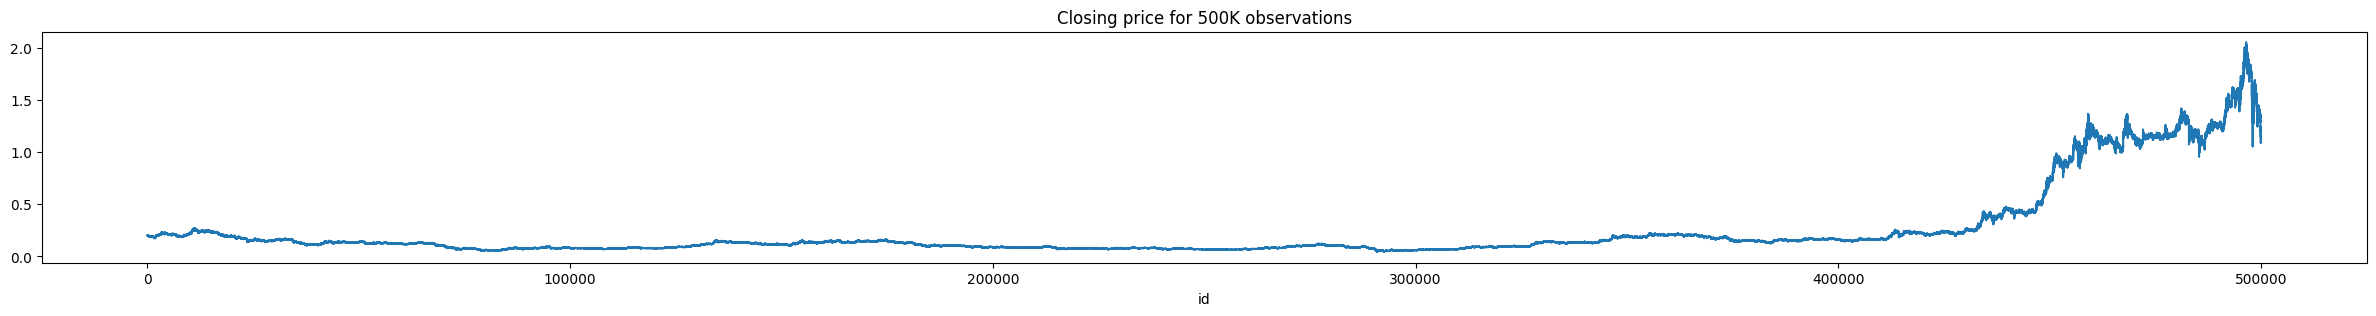

In [45]:
tXY['Close'].plot(figsize=(30,3), title='Closing price for 500K observations');

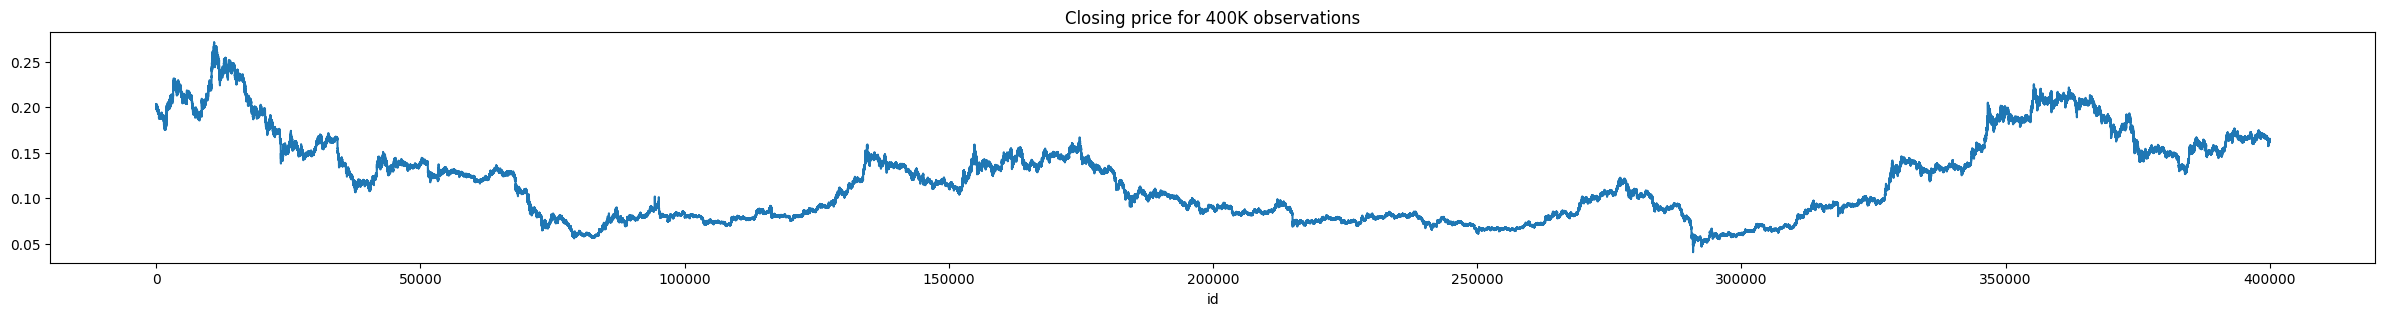

In [73]:
tXY['Close'][:400000].plot(figsize=(30,3), title='Closing price for 400K observations');

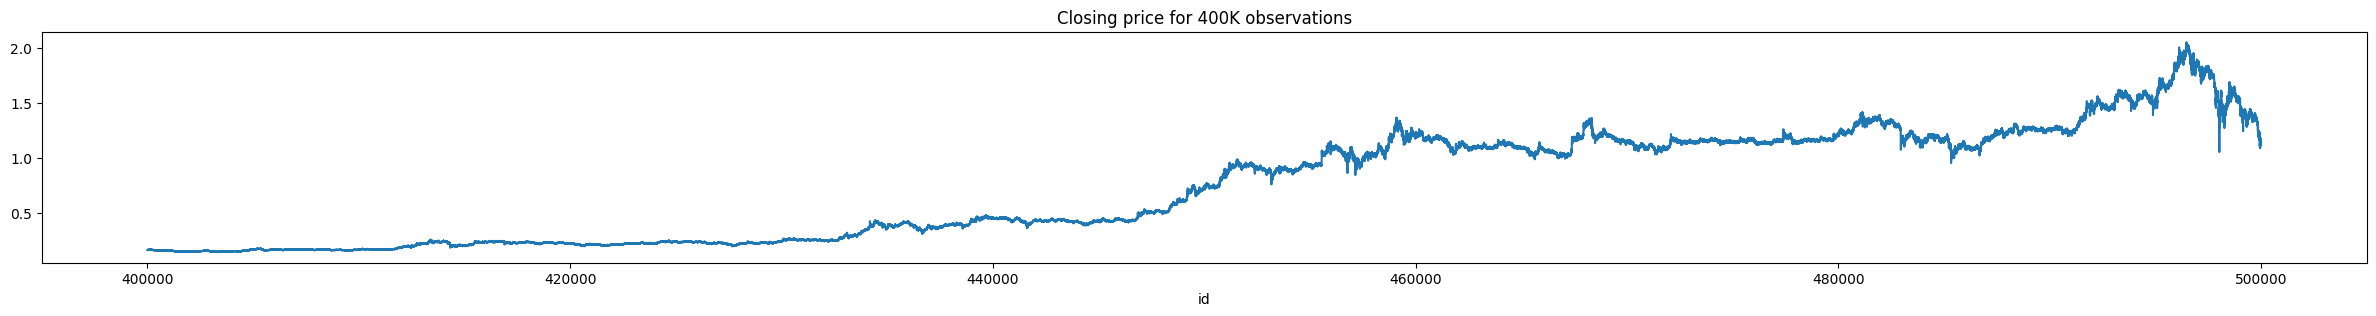

In [74]:
tXY['Close'][400000:500000].plot(figsize=(30,3), title='Closing price for 400K observations');


In [46]:
tXY.nunique()

Count      5477
Open      14973
High      15065
Low       14947
Close     14983
Volume     6485
VWAP      14947
dtype: int64

In [50]:
tXY.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/9g/y_c7n71j1h7_qfrssnpsr4pc0000gn/T/ipykernel_1771/4045513110.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  tXY.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,Count,Open,High,Low,Close,Volume,VWAP
Count,1.00,0.58,0.59,0.58,0.58,0.56,0.58
Open,0.58,1.00,1.00,1.00,1.00,0.32,1.00
High,0.59,1.00,1.00,1.00,1.00,0.33,1.00
Low,0.58,1.00,1.00,1.00,1.00,0.32,1.00
Close,0.58,1.00,1.00,1.00,1.00,0.32,1.00
Volume,0.56,0.32,0.33,0.32,0.32,1.00,0.32
VWAP,0.58,1.00,1.00,1.00,1.00,0.32,1.00


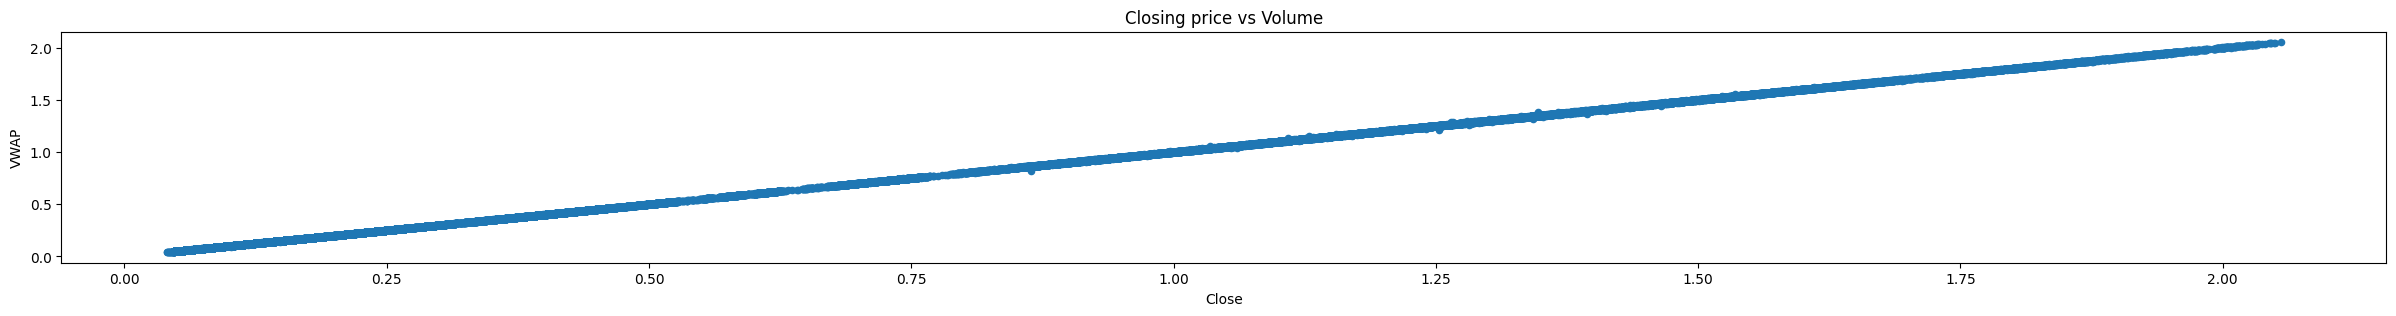

In [7]:
tXY.plot.scatter(x='Close', y='VWAP', figsize=(30,3), title='Closing price vs Volume');


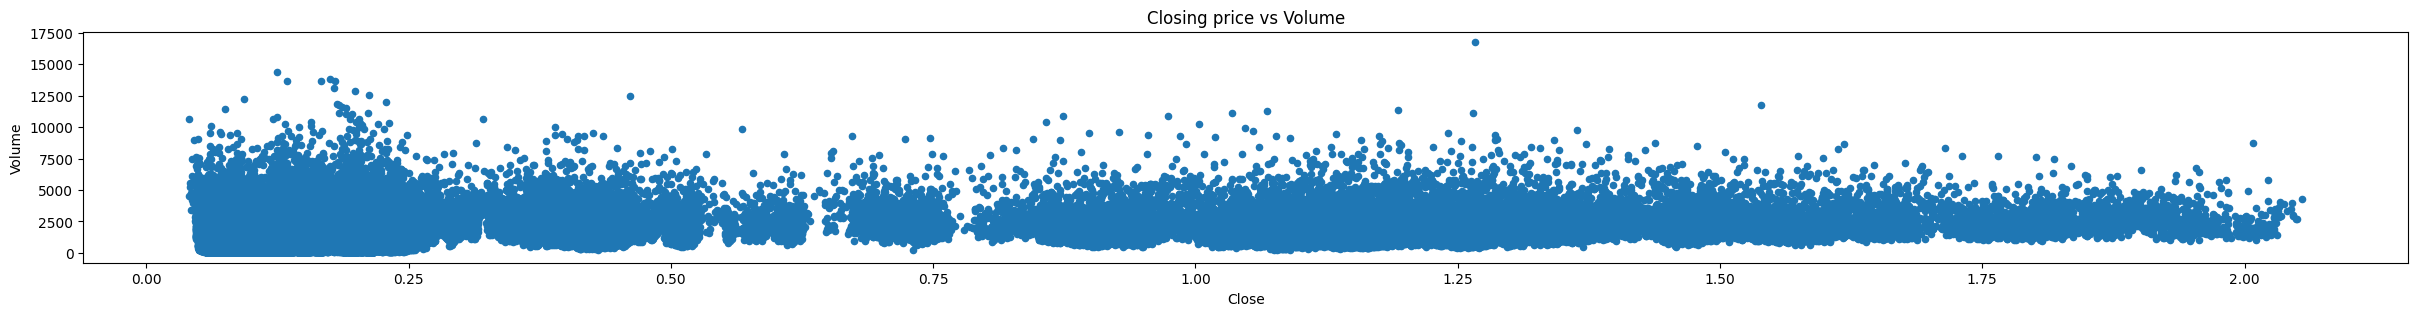

In [6]:
tXY.plot.scatter(x='Close', y='Volume', figsize=(30,3), title='Closing price vs Volume');

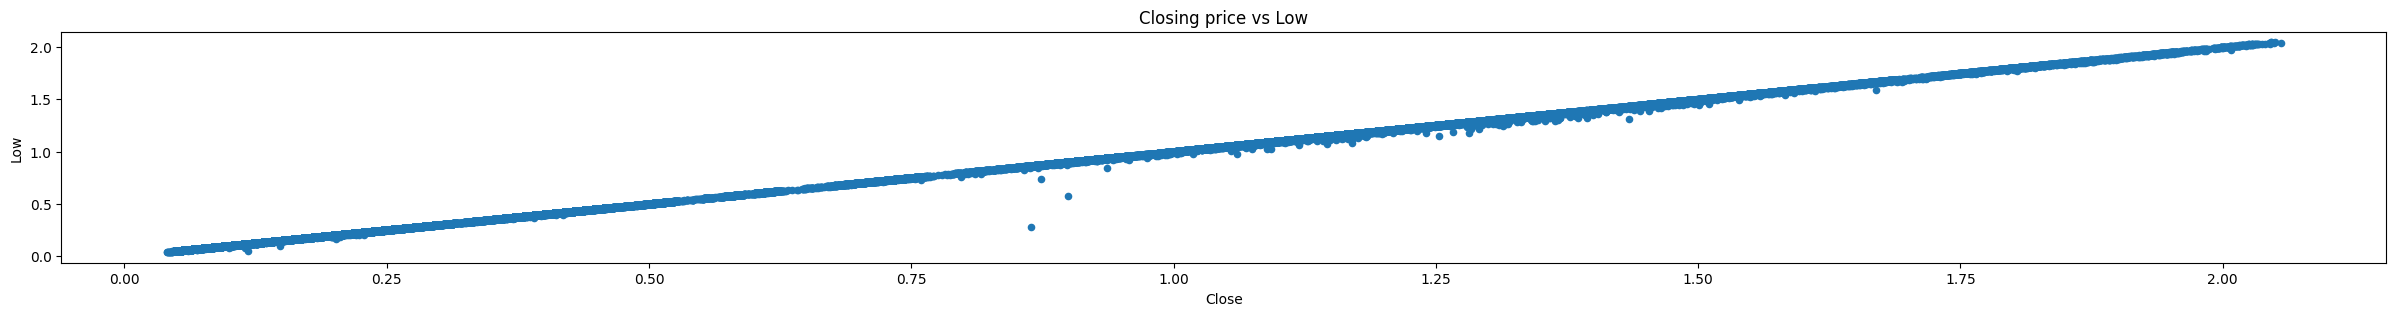

In [8]:
tXY.plot.scatter(x='Close', y='Low', figsize=(30,3), title='Closing price vs Low');


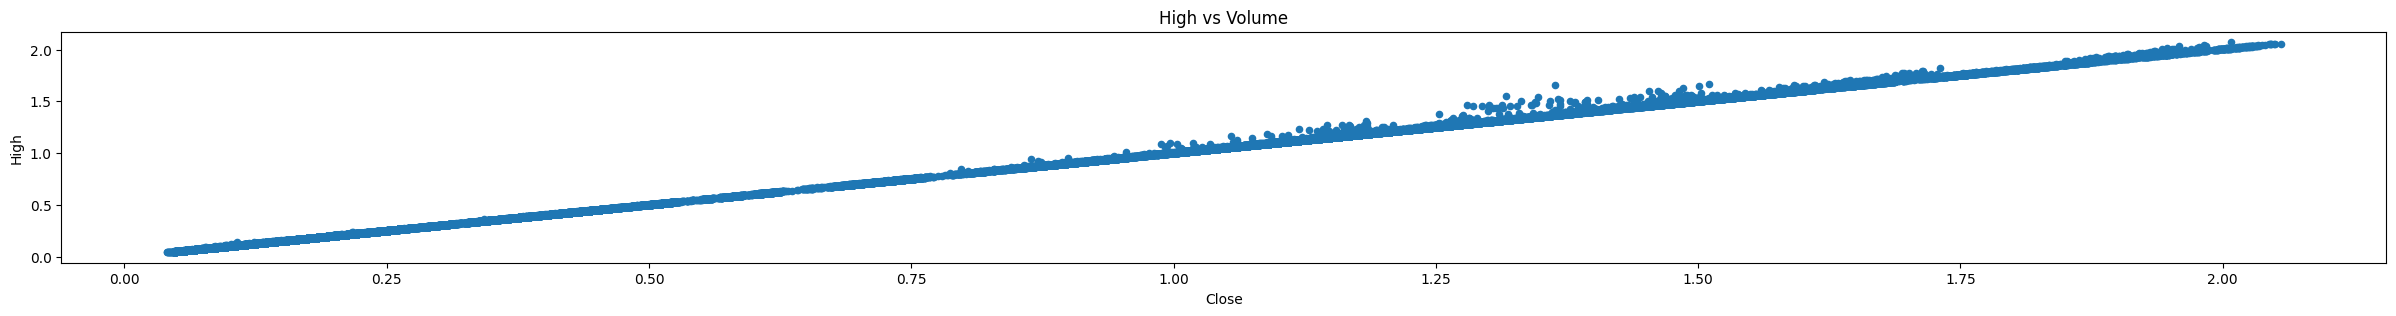

In [9]:
tXY.plot.scatter(x='Close', y='High', figsize=(30,3), title='High vs Volume');


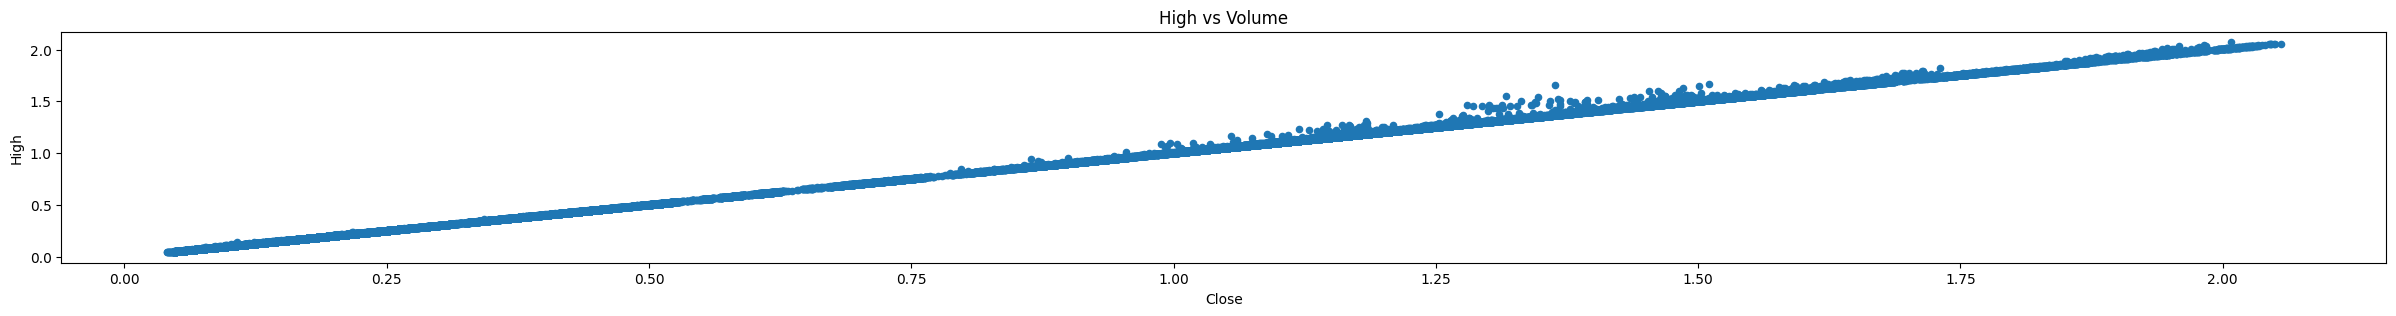

In [10]:
tXY.plot.scatter(x='Close', y='High', figsize=(30,3), title='High vs Volume');


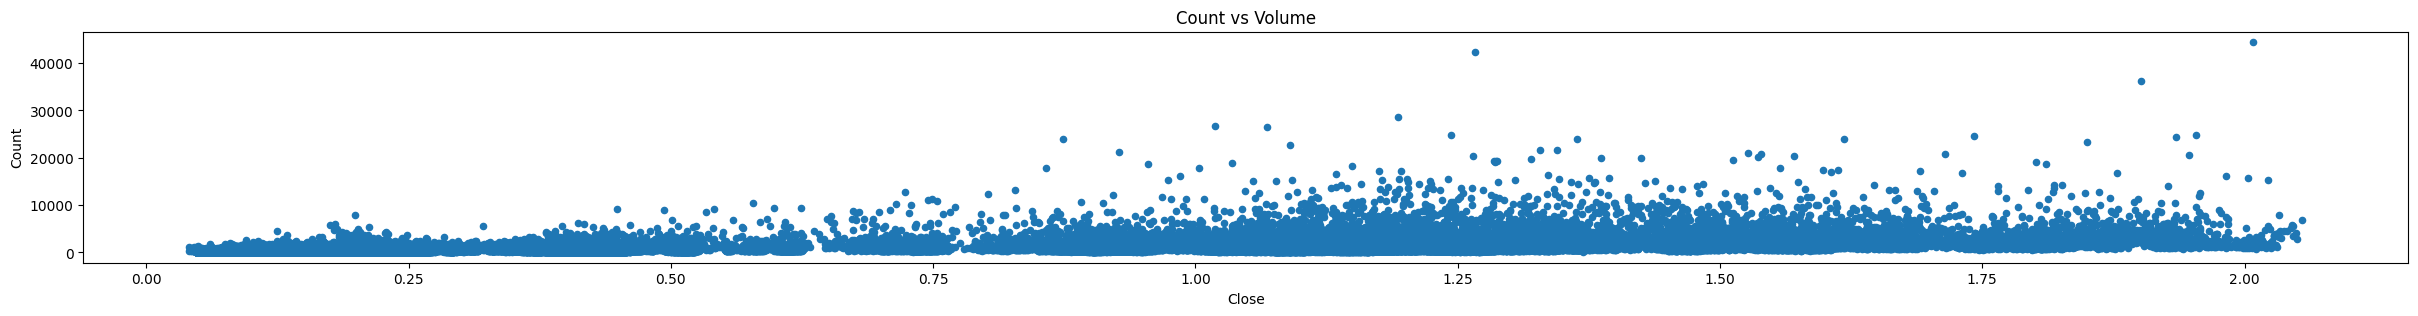

In [11]:
tXY.plot.scatter(x='Close', y='Count', figsize=(30,3), title='Count vs Volume');


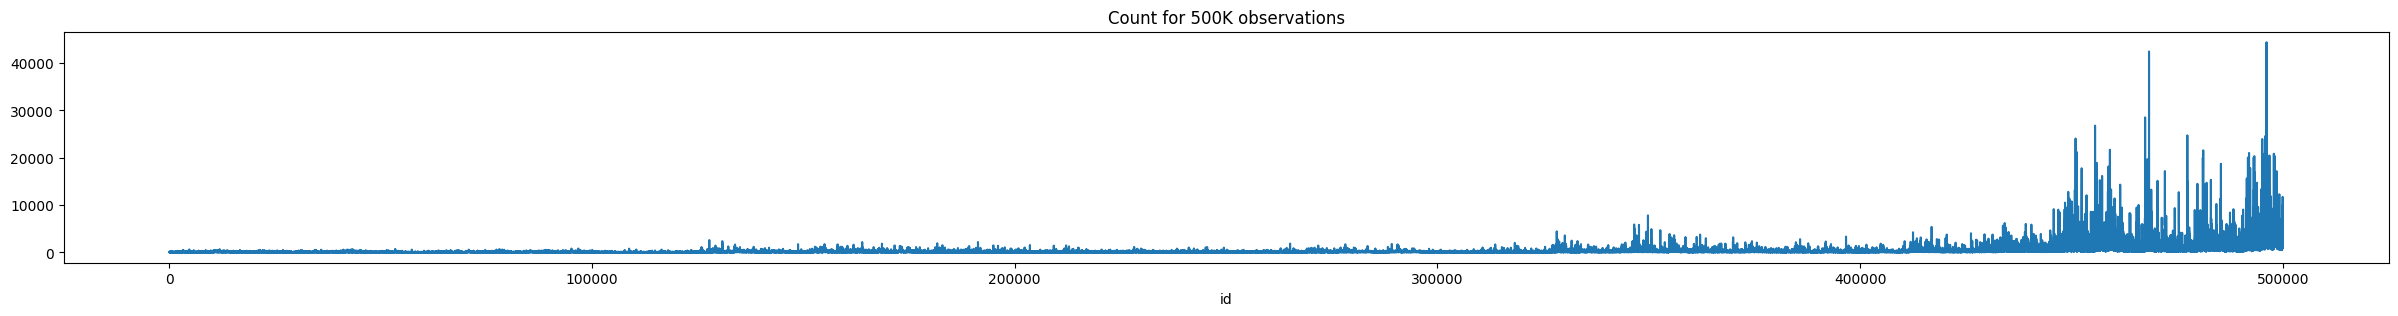

In [14]:
tXY['Count'].plot(figsize=(30,3), title='Count for 500K observations');

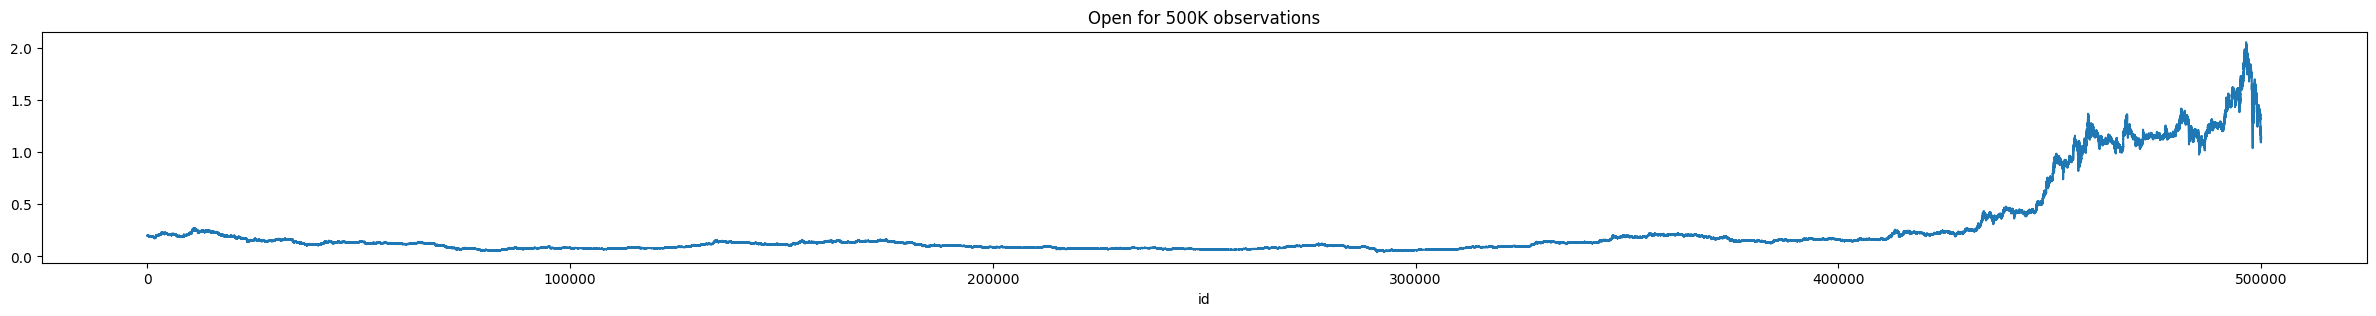

In [16]:
tXY['Open'].plot(figsize=(30,3), title='Open for 500K observations');

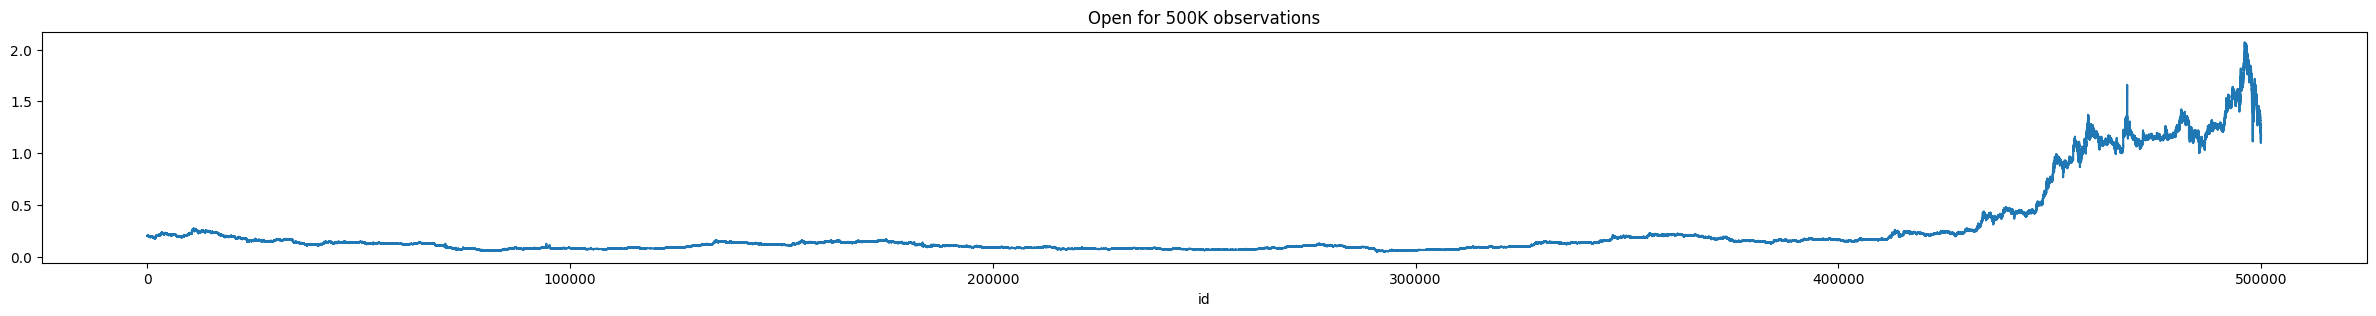

In [17]:
tXY['High'].plot(figsize=(30,3), title='Open for 500K observations');


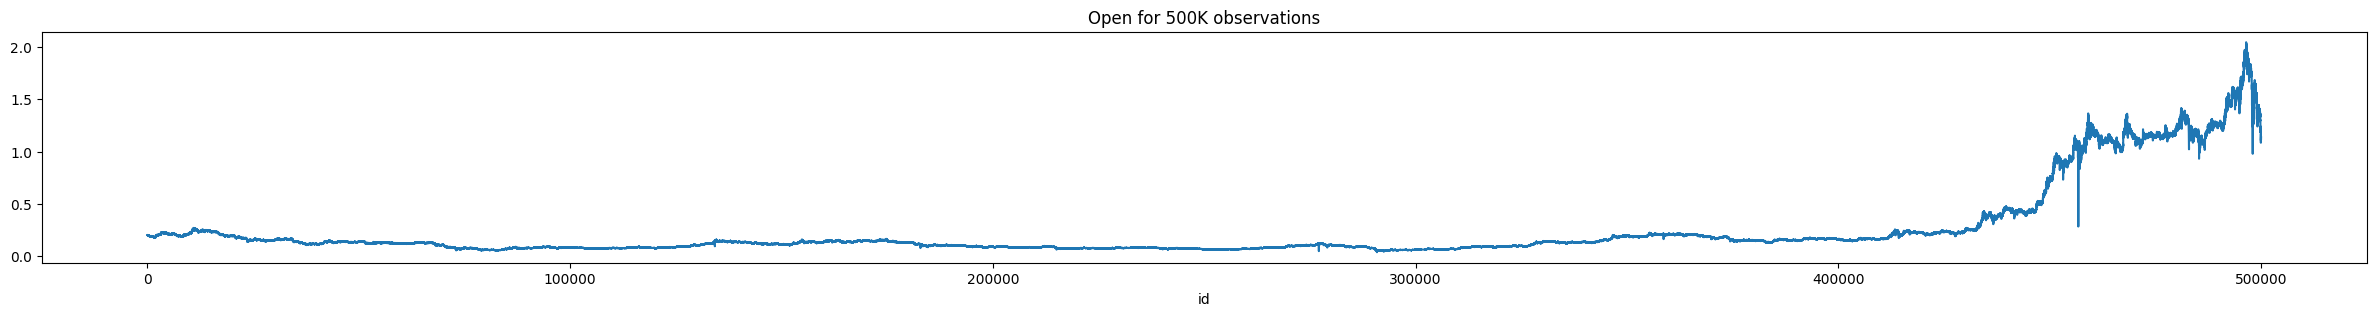

In [18]:
tXY['Low'].plot(figsize=(30,3), title='Open for 500K observations');


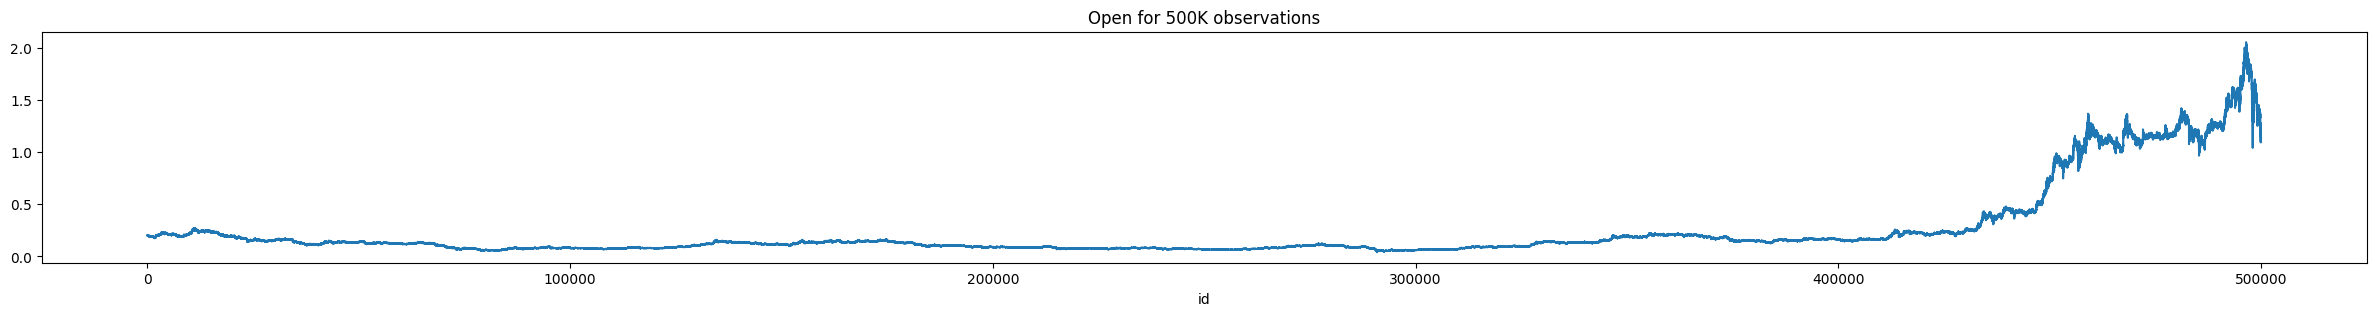

In [19]:
tXY['VWAP'].plot(figsize=(30,3), title='Open for 500K observations');


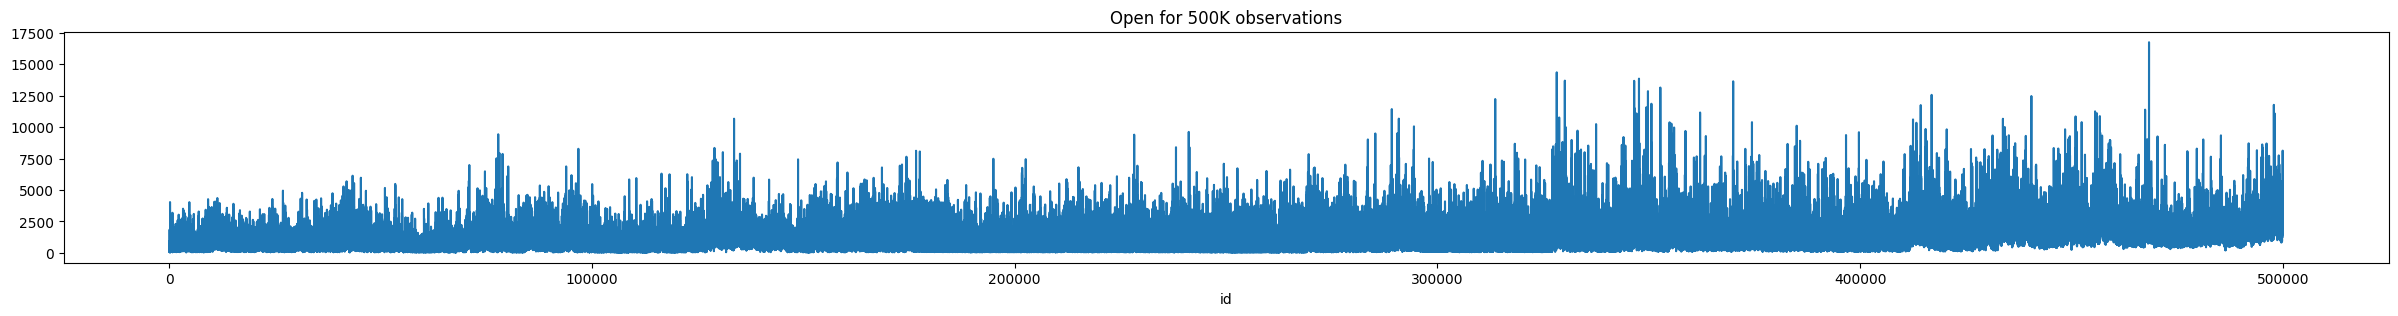

In [20]:
tXY['Volume'].plot(figsize=(30,3), title='Open for 500K observations');


# OBSERVATIONS

Split observataions into blocks of temporal train and test sets

In [26]:
K, (N, p), Nx, Ny = 80000, tXY.shape, 20000, len(pY)  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(tXY.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXY.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y
print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors

df = pd.DataFrame(np.r_[taX[0,:,4], taY[0,:]], columns=['train train price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
pd.DataFrame(taX[0,:,4], columns=['train past price']).plot(grid=True, ax=ax);

KeyboardInterrupt: 

In [16]:
print(K, (N, p), Nx, Ny)

50 (500000, 7) 20000 24431


In [17]:
print(N-Ny-K, N-Ny)

475519 475569


# SCALE THE DATA

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Reshape taX to have shape (K * Nx, p)
taX_reshaped = taX.reshape(-1, p)

# Scale taX and taY
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()


taX_scaled = scaler_X.fit_transform(taX_reshaped)
taY_scaled = scaler_Y.fit_transform(taY)

# Reshape taX back to its original shape
taX_scaled = taX_scaled.reshape(K, Nx, p)

# Print the shapes to verify
print(f'taX_scaled.shape = {taX_scaled.shape}, taY_scaled.shape = {taY_scaled.shape}')


ValueError: cannot reshape array of size 11200000 into shape (80000,20000,7)

# SPLIT THE DATA

In [8]:
# from sklearn.model_selection import train_test_split
# taX_train, taX_val, taY_train, taY_val = train_test_split(taX, taY, test_size=0.1, random_state=42)

# MODEL

Build and Fit RNN

In [42]:
%%time
tf.random.set_seed(0)   # always seed your experiments
Init = tf.keras.initializers.GlorotUniform(seed=0) # seed all that you can

m = Sequential(
  [LSTM(100, return_sequences=True, input_shape=[None, p], name='LSTM1', kernel_initializer=Init, recurrent_initializer=Init),
  Dropout(.2, name='d1'),
  LSTM(100, name='LSTM2', kernel_initializer=Init, recurrent_initializer=Init),
  Dropout(.2, name='d2'),
  Dense(Ny, name='out', kernel_initializer=Init) ], name='RNN_model') # we build Ny forecasts
m.summary()
m.compile(optimizer='adam', loss='mean_squared_error')
hist = m.fit(taX_scaled, taY_scaled, epochs=6, batch_size=32, validation_split=0.1, shuffle=False)

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, None, 100)         43200     
                                                                 
 d1 (Dropout)                (None, None, 100)         0         
                                                                 
 LSTM2 (LSTM)                (None, 100)               80400     
                                                                 
 d2 (Dropout)                (None, 100)               0         
                                                                 
 out (Dense)                 (None, 24431)             2467531   
                                                                 
Total params: 2591131 (9.88 MB)
Trainable params: 2591131 (9.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6


2024-04-10 20:01:44.722881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 20:01:44.895508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 20:01:45.109202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 20:01:46.393101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 20:01:46.847740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 0.3266

2024-04-10 20:01:52.941446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 20:01:52.993952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 20:01:53.163994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 10s 5s/step - loss: 0.3266 - val_loss: 0.3374
Epoch 2/6
2/2 [==============================] - 8s 4s/step - loss: 0.3138 - val_loss: 0.3071
Epoch 3/6
2/2 [==============================] - 8s 4s/step - loss: 0.2783 - val_loss: 0.2463
Epoch 4/6
2/2 [==============================] - 8s 4s/step - loss: 0.2151 - val_loss: 0.1749
Epoch 5/6
2/2 [==============================] - 8s 4s/step - loss: 0.1457 - val_loss: 0.1151
Epoch 6/6
2/2 [==============================] - 8s 4s/step - loss: 0.0906 - val_loss: 0.0830
CPU times: user 13 s, sys: 4.38 s, total: 17.4 s
Wall time: 49 s


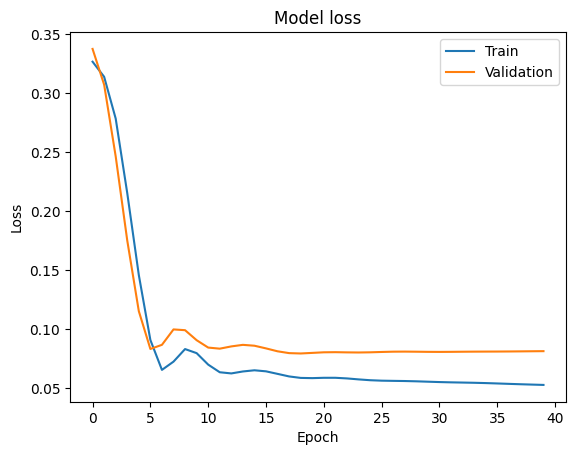

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.savefig('baseline_scaled.png')
plt.show()

# VISUALIZE FORECASTS

<font color=green>The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

/Users/mukulsherekar/venv-metal/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
2024-04-10 19:41:29.662201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 19:41:29.722784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-10 19:41:30.553010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


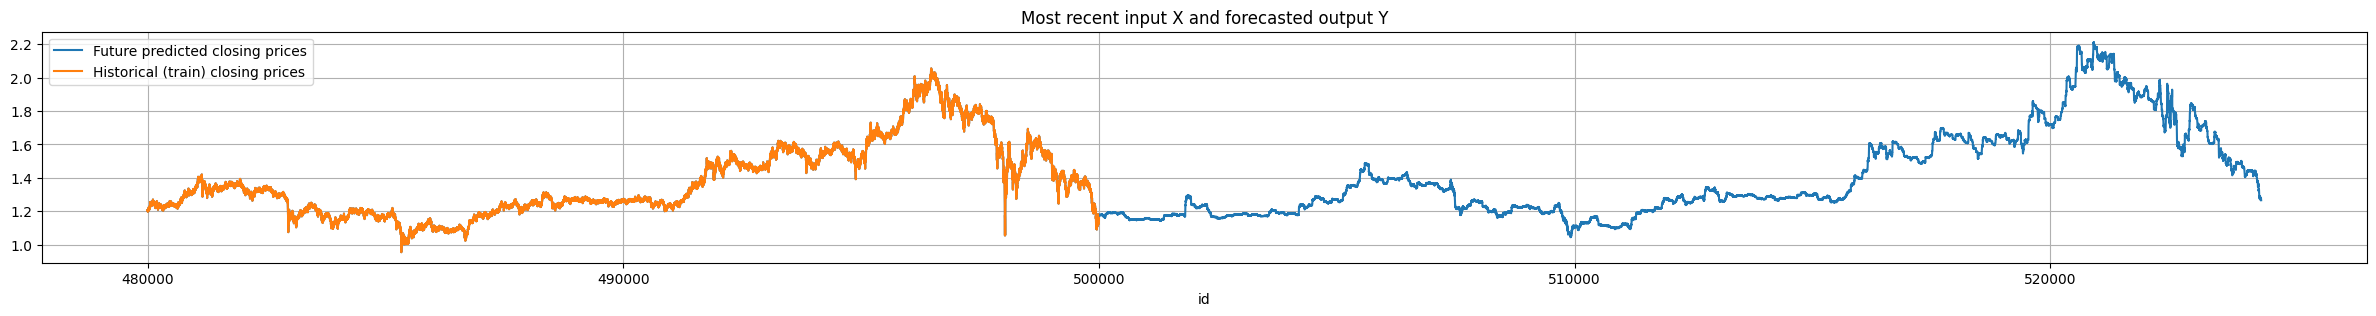

In [13]:
tX_recent = tXY.iloc[-Nx:,:]
tX_recent_scaled = scaler_X.transform(tX_recent)
tX_recent_scaled_reshaped = tX_recent_scaled.reshape(1, Nx, p)
predicted_scaled = m.predict(tX_recent_scaled_reshaped)
predicted = scaler_Y.inverse_transform(predicted_scaled).flatten()
pY['Close'] = predicted

ax = pd.concat([tX_recent.Close, pY.Close]).plot(figsize=(30, 3), title='Most recent input X and forecasted output Y')
tX_recent.Close.plot(ax=ax, grid=True)
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);



# PREDICTIONS

In [14]:
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
ToCSV(pY, '📈shuffle🐍')

# model experimentation

In [35]:
%%time
tf.random.set_seed(0)   # always seed your experiments
Init = tf.keras.initializers.GlorotUniform(seed=0) # seed all that you can


model = Sequential()
model.add(Input(shape=[None, p]))
for rate in (1, 2, 4, 8) * 2:
    model.add(Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
                                  
model.add(Conv1D(filters=30, kernel_size=3, padding="causal", activation="relu", dilation_rate=1))
model.add(Dropout(0.2))
model.add(Conv1D(filters=40, kernel_size=3, padding="causal", activation="relu", dilation_rate=2))
model.add(Dropout(0.2))

model.add(GRU(10, kernel_initializer=Init, recurrent_initializer=Init))

model.add(Dense(Ny, kernel_initializer=Init))

model.summary()
model.compile(loss="mse", optimizer='adam',metrics=[last_time_step_mse])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, None, 20)          300       
                                                                 
 conv1d_37 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_38 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_39 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_40 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_41 (Conv1D)          (None, None, 20)          820       
                                                                 
 conv1d_42 (Conv1D)          (None, None, 20)         

NameError: name 'last_time_step_mse' is not defined